# 1. PCA for Network Intrusion Detection

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

def load_kdd_data(data_dir="./datasets/kdd_balanced"):
    """
    Load the balanced dataset from Parquet format (ultra-fast loading).
    
    Returns:
        D_balanced: Feature matrix (numpy array)
        is_normal_balanced: Boolean labels (numpy array)  
        original_indices: Original indices from full dataset (numpy array)
        df_balanced: Original dataframe subset (if available)
        metadata: Dataset metadata
    """
    from pathlib import Path
    import numpy as np
    import pandas as pd
    import json
    
    data_path = Path(data_dir)
    
    # Check if required files exist
    required_files = ["balanced_dataset.parquet", "metadata.json"]
    missing_files = [f for f in required_files if not (data_path / f).exists()]
    if missing_files:
        raise FileNotFoundError(f"Required files not found in {data_path}: {missing_files}")
    
    # Load main dataset (this is very fast with Parquet)
    df_main = pd.read_parquet(data_path / "balanced_dataset.parquet")
    
    # Extract components
    feature_cols = [col for col in df_main.columns if col.startswith('feature_')]
    D_balanced = df_main[feature_cols].values
    is_normal_balanced = df_main['is_normal'].values
    original_indices = df_main['original_index'].values
    
    # Load original dataframe if available
    df_balanced = None
    if (data_path / "original_data_balanced.parquet").exists():
        df_balanced = pd.read_parquet(data_path / "original_data_balanced.parquet")
    
    # Load metadata
    with open(data_path / "metadata.json", 'r') as f:
        metadata = json.load(f)
    
    print(f"Balanced dataset loaded from {data_path} (Parquet format)")
    print(f"  Features: {D_balanced.shape}")
    print(f"  Normal: {metadata['n_normal']:,}, Intrusion: {metadata['n_intrusion']:,}")
    
    return D_balanced, is_normal_balanced, original_indices, df_balanced, metadata

def compute_pca_from_intrusion_data(D_intrusion, r):
    """
    Compute PCA using SVD on intrusion data with rank r.
    
    Key insight: We train PCA on INTRUSION data, so normal data
    will have higher reconstruction error in this learned space.
    
    Returns:
        X: Principal components (learned from intrusion data)
        mu_intrusion: Mean vector of intrusion data
    """


def project_to_low_dimensional_space(D, X, mu_intrusion):
    """
    Project any data points into the low-dimensional space defined by
    intrusion-trained PCA components.
    """


def reconstruct_from_low_dimensional(Y, X, mu_intrusion):
    """Reconstruct data points from low-dimensional coordinates."""


def compute_reconstruction_error(original, reconstructed):
    """Compute L2 reconstruction error."""


In [3]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Step 1: Load the full dataset
D, is_normal, original_indices, df_balanced, metadata = load_kdd_data()

# Step 2: Compute mean vector of full dataset
mu = D.mean(axis=0)

# Step 3: Center the dataset
C = D - mu

# Step 4: Apply PCA (Truncated SVD) with rank r=10
r = 10
svd = TruncatedSVD(n_components=r)
Y = svd.fit_transform(C)  # Low-dimensional representations of all data points
X = svd.components_.T     # Principal components

# Step 5: Get the low-dimensional representation of the 8th data point (index 7)
y8 = Y[7]

# Step 6: Report first three coordinates
print("First three coordinates of the 8th data point (low-dimensional representation):")
print(y8[:3])


Balanced dataset loaded from datasets\kdd_balanced (Parquet format)
  Features: (97378, 118)
  Normal: 97,278, Intrusion: 100
First three coordinates of the 8th data point (low-dimensional representation):
[-0.09908221 -0.99311985 -0.06296968]


In [9]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Step 1: Load data
D, is_normal, original_indices, df_balanced, metadata = load_kdd_data()

# Step 2: Compute mean and center data
mu = D.mean(axis=0)
C = D - mu

# Step 3: Train PCA (rank 10)
r = 10
svd = TruncatedSVD(n_components=r)
Y = svd.fit_transform(C)
X = svd.components_.T  # shape (n_features, r)

# Step 4: Reconstruct all points
C_hat = Y @ X.T       # low-rank approximation in centered space
D_hat = C_hat + mu    # add mean back to get reconstructed points

# Step 5: Compute reconstruction error for each point
reconstruction_errors = np.sum((D - D_hat)**2, axis=1)

# Step 6: Get required values
error_8 = reconstruction_errors[7]
mean_error_intrusion = np.mean(reconstruction_errors[~is_normal])
mean_error_normal = np.mean(reconstruction_errors[is_normal])

# Step 7: Report
print(f"Reconstruction error of 8th data point: {error_8:.4f}")
print(f"Mean reconstruction error (intrusion): {mean_error_intrusion:.4f}")
print(f"Mean reconstruction error (normal): {mean_error_normal:.4f}")


Balanced dataset loaded from datasets\kdd_balanced (Parquet format)
  Features: (97378, 118)
  Normal: 97,278, Intrusion: 100
Reconstruction error of 8th data point: 3.5494
Mean reconstruction error (intrusion): 30.1167
Mean reconstruction error (normal): 12.8758


In [ ]:
import numpy as np

# --- Assumes you already computed reconstruction_errors and is_normal as before ---

# Step 1: Compute percentiles
percentiles = [90, 95, 99]
thresholds = np.percentile(reconstruction_errors, percentiles)

# Step 2: For each threshold, compute TP and FP
for p, thresh in zip(percentiles, thresholds):
    is_outlier = reconstruction_errors >= thresh
    tp = np.sum((~is_normal) & is_outlier)  
    fp = np.sum(is_normal & is_outlier)     
    print(f"For {p}th percentile threshold:")
    print(f"  tp_{p} = {tp}")
    print(f"  fp_{p} = {fp}")


For 90th percentile threshold:
  tp_90 = 99
  fp_90 = 9639
For 95th percentile threshold:
  tp_95 = 38
  fp_95 = 4831
For 99th percentile threshold:
  tp_99 = 2
  fp_99 = 972


# 2. K-means Initialization

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
from pathlib import Path

RANDOM_SEED = 42

def load_iris_data(path=Path("datasets/iris/iris.csv")):
    df = pd.read_csv(path)
    data = df.iloc[:, :-1].values
    labels = df['target'].values
    return data, labels

def print_iris_info(data, labels):
    n_samples, n_features = data.shape
    n_classes = len(np.unique(labels))
    feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width']

    print(f"Number of samples: {n_samples}")
    print(f"Number of features: {n_features}")
    print(f"Number of classes: {n_classes}")
    print(f"Feature names: {feature_names}")
    print(f"Class distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples")

def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    rng =  np.random.default_rng(seed=RANDOM_SEED) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    # Your code here

    indexes = rng.integers(low=0, high=n, size=r)
    X = np.array(D[indexes,:]).T
    return X

# K-means implementation from the lecture slides
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
    
def getY(labels):
    Y = np.eye(max(labels)+1)[labels]
    return Y
    
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
    
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
    
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y


data, labels = load_iris_data()

# Your code here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
from pathlib import Path

RANDOM_SEED = 42

def load_iris_data(path=Path("datasets/iris/iris.csv")):
    df = pd.read_csv(path)
    data = df.iloc[:, :-1].values
    labels = df['target'].values
    return data, labels

def print_iris_info(data, labels):
    n_samples, n_features = data.shape
    n_classes = len(np.unique(labels))
    feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width']

    print(f"Number of samples: {n_samples}")
    print(f"Number of features: {n_features}")
    print(f"Number of classes: {n_classes}")
    print(f"Feature names: {feature_names}")
    print(f"Class distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples")

def init_centroids_greedy_pp(D, r, l=10):
    rng = np.random.default_rng(seed=RANDOM_SEED)
    n, d = D.shape

    # Step 1: Initial random candidates
    candidate_idxs = rng.choice(n, size=l, replace=False)
    sum_dists = [np.sum(np.linalg.norm(D - D[i], axis=1)**2) for i in candidate_idxs]
    best_first_idx = candidate_idxs[np.argmin(sum_dists)]
    X = D[best_first_idx].reshape(1, -1)  # First centroid

    # Step 2: Greedily select remaining centroids
    while X.shape[0] < r:
        # Compute distances to the closest centroid for all points
        dists = np.min([np.linalg.norm(D - x, axis=1)**2 for x in X], axis=0)
        probs = dists / np.sum(dists)
        
        # Sample l candidates with replacement
        candidate_idxs = rng.choice(n, size=l, p=probs, replace=False)
        
        # Select the candidate that would best reduce total distance
        min_total_dist = np.inf
        best_idx = None
        for idx in candidate_idxs:
            new_X = np.vstack([X, D[idx]])
            new_dists = np.min([np.linalg.norm(D - x, axis=1)**2 for x in new_X], axis=0)
            total_dist = np.sum(new_dists)
            if total_dist < min_total_dist:
                min_total_dist = total_dist
                best_idx = idx
        
        X = np.vstack([X, D[best_idx]])

    return X.T  # shape (d, r)

    # Your code here

    indexes = rng.integers(low=0, high=n, size=r)
    X = np.array(D[indexes,:]).T
    return X

# K-means implementation from the lecture slides
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
    
def getY(labels):
    Y = np.eye(max(labels)+1)[labels]
    return Y
    
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
    
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
    
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y


data, labels = load_iris_data()

data, labels = load_iris_data()
n, d = data.shape
r = 3
l = 10

# Initialize centroids
X_init = init_centroids_greedy_pp(data, r, l)

# Run k-means
X_final, Y_final = kmeans(data, r, X_init)

# Recover cluster labels from one-hot Y
cluster_labels = np.argmax(Y_final, axis=1)

from sklearn.metrics import normalized_mutual_info_score

# Mean approximation error
approx_error = RSS(data, X_final, Y_final) / (n * d)
print(f"Mean approximation error: {approx_error:.4f}")

# Normalized Mutual Information
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")



10 iterations
Mean approximation error: 0.1314
Normalized Mutual Information (NMI): 0.7419


# 3. Netflix Recommender System

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd


def load_ratings_data_pandas(data_dir="ml-latest-small/"):
    """Load data using pandas dataframes."""
    data_dir = Path(data_dir)
    assert data_dir.exists(), f"{data_dir} does not exist"

    return pd.read_csv(data_dir / 'ratings.csv',sep=',')


def load_movies_data_pandas(data_dir="ml-latest-small/"):
    """Load data using pandas dataframes."""
    data_dir = Path(data_dir)
    assert data_dir.exists(), f"{data_dir} does not exist"
    return pd.read_csv(data_dir / 'movies.csv')


def filter_data(ratings_data: pd.DataFrame, movies_data: pd.DataFrame):
    """Filter data. Too little ratings prevent effective use of matrix completion."""
    ratings_data = ratings_data.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    ).fillna(0)

    keep_movie = (ratings_data != 0).sum(axis=0) > 100
    ratings_data = ratings_data.loc[:, keep_movie]

    # Filter movies_data by movieId (columns of ratings_data after filtering)
    movies_data = movies_data[movies_data['movieId'].isin(ratings_data.columns)]

    keep_user = (ratings_data != 0).sum(axis=1) >= 5
    ratings_data = ratings_data.loc[keep_user, :]

    return ratings_data, movies_data


def print_data_summary(ratings: pd.DataFrame):
    n_users = ratings.shape[0]
    n_movies = ratings.shape[1]
    n_ratings = (ratings != 0).sum().sum()
    density = n_ratings / (n_users * n_movies)

    print(f"Dataset Summary")
    print(f"----------------")
    print(f"Users: {n_users}")
    print(f"Movies: {n_movies}")
    print(f"Total Ratings: {n_ratings}")
    print(f"Data Density: {density:.4f} (fraction of observed ratings)")


def load_ratings_data(data_dir="ml-latest-small/", print_summary=False):
    """Load data in numpy format."""
    ratings, movies = filter_data(
        load_ratings_data_pandas(data_dir=data_dir),
        load_movies_data_pandas(data_dir=data_dir)
    )
    if print_summary:
        print_data_summary(ratings)
    return ratings.to_numpy()


def matrix_completion(D, n_features, n_movies, n_users, t_max=100, lambd=0.1):
    np.random.seed(0)
    X = np.random.normal(size=(n_movies, n_features))
    Y = np.random.normal(size=(n_users, n_features))

    # Implementation the optimization procedure here
    raise NotImplementedError

    return X, Y

In [3]:
ratings = load_ratings_data("datasets/ml-latest-small", print_summary=True)

Dataset Summary
----------------
Users: 556
Movies: 134
Total Ratings: 19694
Data Density: 0.2643 (fraction of observed ratings)


# 4. Image Classification With Neural Networks

In [4]:
"""
CNN Embedding Space Visualization

This educational module demonstrates:
- ResNet-style architecture with skip connections
- Embedding space learning for visualization
- Domain transfer between MNIST and Fashion-MNIST
- Decision boundary visualization
"""

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Optional, Callable
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


@dataclass
class Config:
    """Configuration parameters for the model and training."""

    # Model architecture
    embedding_dim: int = 2
    num_classes: int = 10

    # Training hyperparameters
    learning_rate: float = 0.9 
    momentum: float = 0.9
    weight_decay: float = 5e-4
    batch_size: int = 128
    epochs: int = 5
    dropout_rate_1: float = 0.9
    dropout_rate_2: float = 0.9

    # Visualization
    viz_samples: int = 100
    viz_zoom: float = 0.7
    grid_resolution: float = 0.1 
    
    # Paths
    checkpoint_dir: Path = Path("checkpoint")
    model_filename: str = "embedding_model.pth"

    @property
    def device(self) -> str:
        """Get the appropriate device for computation."""
        return 'cuda' if torch.cuda.is_available() else 'cpu'


class ResidualBlock(nn.Module):
    """
    Residual block with skip connections and grouped convolutions.

    Implements: output = input + F(input)
    where F is a residual function composed of BatchNorm→ReLU→Conv layers.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, groups: int = 1):
        super().__init__()

        groups = min(groups, min(in_channels, out_channels))

        # Main convolution pathway
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size,
                              padding="same", groups=groups)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size,
                              padding="same", groups=min(groups, out_channels))

        # Skip connection (identity or dimension adjustment)
        self.skip_connection = (
            nn.Identity() if in_channels == out_channels
            else nn.Conv2d(in_channels, out_channels, kernel_size=1, padding="same")
        )

        # Pre-activation normalization layers
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass implementing residual connection."""
        identity = self.skip_connection(x)

        # Residual pathway: BatchNorm → ReLU → Conv → BatchNorm → ReLU → Conv
        out = self.conv1(self.relu(self.norm1(x)))
        out = self.conv2(self.relu(self.norm2(out)))

        return identity + out


class EmbeddingNetwork(nn.Module):
    """
    CNN that maps input images to low-dimensional embedding space.

    Uses global average pooling instead of flattening to reduce overfitting
    and make the model robust to different input sizes.
    """

    def __init__(self, embedding_dim: int, dropout_rate_1: float, dropout_rate_2: float):
        super().__init__()

        # Initial feature extraction
        self.initial_conv = nn.Conv2d(1, 32, kernel_size=5, padding="same")
        self.initial_norm = nn.BatchNorm2d(32)

        # First residual block set (32 channels, groups=2)
        self.res_block1 = ResidualBlock(32, 32, kernel_size=3, groups=2)
        self.res_block2 = ResidualBlock(32, 32, kernel_size=3, groups=2)

        # Spatial downsampling
        self.pool = nn.MaxPool2d(2)
        self.norm_after_pool = nn.BatchNorm2d(32)

        # Second residual block set (64 channels, groups=4)
        self.res_block3 = ResidualBlock(32, 64, kernel_size=3, groups=4)
        self.res_block4 = ResidualBlock(64, 64, kernel_size=3, groups=4)

        # Final processing
        self.final_norm = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

        # Regularization
        self.dropout1 = nn.Dropout(dropout_rate_1)
        self.dropout2 = nn.Dropout(dropout_rate_2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass mapping images to embedding space.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Embedding tensor of shape (batch_size, embedding_dim)
        """
        out = F.relu(self.initial_norm(self.initial_conv(x)))

        # out.shape = ? (tensor shape 1)

        # First round of residual blocks
        out = self.res_block2(self.res_block1(out))

        # out.shape = ? (tensor shape 2)

        # Pooling
        out = self.norm_after_pool(self.pool(out))

        # out.shape = ? (tensor shape 3)

        # Second round of residual blocks
        out = self.res_block4(self.res_block3(out))

        # out.shape = ? (tensor shape 4)

        # Global average pooling
        out = torch.mean(out, dim=(-1, -2))
        out = self.final_norm(out)

        # out.shape = ? (tensor shape 5)

        # Map to embedding space
        out = self.dropout1(out)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)

        return out


class EmbeddingClassifier(nn.Module):
    """Complete model combining embedding network with classifier."""

    def __init__(self, embedding_dim: int, num_classes: int, config: Config):
        super().__init__()
        self.embedding_net = EmbeddingNetwork(
            embedding_dim, config.dropout_rate_1, config.dropout_rate_2
        )
        self.classifier = nn.Linear(embedding_dim, num_classes, bias=True)

        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass for training and evaluation."""
        embeddings = self.embedding_net(x)
        return self.classifier(embeddings)

    def get_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        """Extract embeddings for visualization."""
        return self.embedding_net(x)

    def get_probabilities(self, x: torch.Tensor) -> torch.Tensor:
        """Get class probabilities for confidence visualization."""
        embeddings = self.embedding_net(x)
        return F.softmax(self.classifier(embeddings), dim=1)


def create_data_loaders(dataset_class, config: Config) -> Tuple[DataLoader, DataLoader]:
    """
    Create training and test data loaders.

    Args:
        dataset_class: torchvision dataset class (MNIST or FashionMNIST)
        config: Configuration object

    Returns:
        Tuple of (train_loader, test_loader)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST standard values
    ])

    # Training data
    train_dataset = dataset_class(root='./data', train=True, download=True, transform=transform)
    if config.num_classes < 10:
        mask = train_dataset.targets < config.num_classes
        train_dataset.targets = train_dataset.targets[mask]
        train_dataset.data = train_dataset.data[mask]

    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )

    # Test data
    test_dataset = dataset_class(root='./data', train=False, download=True, transform=transform)
    if config.num_classes < 10:
        mask = test_dataset.targets < config.num_classes
        test_dataset.targets = test_dataset.targets[mask]
        test_dataset.data = test_dataset.data[mask]

    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    return train_loader, test_loader


@dataclass
class EpochMetrics:
    """Container for epoch training/evaluation metrics."""
    accuracy: float
    avg_confidence: float
    avg_loss: float
    total_samples: int
    elapsed_time: Optional[float] = None


def compute_batch_metrics(logits: torch.Tensor, targets: torch.Tensor, loss: torch.Tensor) -> Tuple[int, float, int]:
    """
    Compute metrics for a single batch.

    Args:
        logits: Model output logits
        targets: Ground truth labels
        loss: Computed loss for the batch

    Returns:
        Tuple of (correct_predictions, total_confidence, batch_size)
    """
    probabilities = F.softmax(logits, dim=1)
    confidences, predictions = probabilities.max(1)

    correct_predictions = predictions.eq(targets).sum().item()
    total_confidence = confidences.sum().item()
    batch_size = targets.size(0)

    return correct_predictions, total_confidence, batch_size


def run_epoch(
    model: nn.Module,
    criterion,
    data_loader: DataLoader,
    device: str,
    optimizer=None,
    is_training: bool = True
) -> EpochMetrics:
    """
    Run one epoch of training or evaluation.

    Args:
        model: PyTorch model
        criterion: Loss function
        data_loader: Data loader
        device: Device to run on
        optimizer: Optimizer (required if is_training=True)
        is_training: Whether to run in training mode

    Returns:
        EpochMetrics containing all computed metrics
    """
    if is_training:
        if optimizer is None:
            raise ValueError("Optimizer required for training mode")
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_confidence = 0.0
    total_samples = 0

    start_time = time.time()
    context_manager = torch.no_grad() if not is_training else torch.enable_grad()

    with context_manager:
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            if is_training:
                optimizer.zero_grad()

            logits = model(inputs)
            loss = criterion(logits, targets)

            if torch.isnan(loss):
                print("Warning: NaN loss detected")

            if is_training:
                loss.backward()
                optimizer.step()

            # Compute batch metrics (always without gradients for metrics)
            with torch.no_grad():
                batch_correct, batch_confidence, batch_size = compute_batch_metrics(logits, targets, loss)

                total_loss += loss.item()
                total_correct += batch_correct
                total_confidence += batch_confidence
                total_samples += batch_size

    # Calculate final metrics
    if total_samples == 0:
        print("Warning: No samples processed")
        return EpochMetrics(0, 0, float('inf'), 0, time.time() - start_time)

    accuracy = 100.0 * total_correct / total_samples
    avg_confidence = 100.0 * total_confidence / total_samples
    avg_loss = total_loss / len(data_loader)
    elapsed_time = time.time() - start_time

    return EpochMetrics(
        accuracy=accuracy,
        avg_confidence=avg_confidence,
        avg_loss=avg_loss,
        total_samples=total_samples,
        elapsed_time=elapsed_time
    )


def train_epoch(model: nn.Module, criterion, optimizer, data_loader: DataLoader, device: str) -> Tuple[float, float]:
    """
    Train model for one epoch.

    Returns:
        Tuple of (accuracy, average_confidence)
    """
    metrics = run_epoch(model, criterion, data_loader, device, optimizer, is_training=True)

    print(f'Train - Loss: {metrics.avg_loss:.3f} | '
          f'Acc: {metrics.accuracy:.3f}% ({int(metrics.accuracy * metrics.total_samples / 100)}/{metrics.total_samples}) | '
          f'Conf: {metrics.avg_confidence:.2f}% | Time: {metrics.elapsed_time:.2f}s')

    return metrics.accuracy, metrics.avg_confidence


def evaluate_model(model: nn.Module, criterion, data_loader: DataLoader, device: str) -> Tuple[float, float]:
    """
    Evaluate model on test data.

    Returns:
        Tuple of (accuracy, average_confidence)
    """
    metrics = run_epoch(model, criterion, data_loader, device, optimizer=None, is_training=False)

    print(f'Test  - Loss: {metrics.avg_loss:.3f} | '
          f'Acc: {metrics.accuracy:.3f}% ({int(metrics.accuracy * metrics.total_samples / 100)}/{metrics.total_samples}) | '
          f'Conf: {metrics.avg_confidence:.2f}%')

    return metrics.accuracy, metrics.avg_confidence


def save_model(model: nn.Module, accuracy: float, config: Config) -> None:
    """Save model checkpoint."""
    config.checkpoint_dir.mkdir(exist_ok=True)

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'accuracy': accuracy,
        'config': {
            'embedding_dim': config.embedding_dim,
            'num_classes': config.num_classes,
            'dropout_rate_1': config.dropout_rate_1,
            'dropout_rate_2': config.dropout_rate_2,
        }
    }

    save_path = config.checkpoint_dir / config.model_filename
    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")


def load_model(config: Config) -> EmbeddingClassifier:
    """Load model from checkpoint."""
    load_path = config.checkpoint_dir / config.model_filename

    model = EmbeddingClassifier(config.embedding_dim, config.num_classes, config)
    checkpoint = torch.load(load_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Model loaded from {load_path}")
    print(f"Loaded model accuracy: {checkpoint['accuracy']:.2f}%")

    return model


def plot_decision_boundary(
    model: EmbeddingClassifier,
    bounds: Tuple[float, float, float, float],
    config: Config,
    show_classes: bool = False
) -> None:
    """
    Plot decision boundary or confidence map in embedding space.

    Args:
        model: Trained model
        bounds: (x_min, x_max, y_min, y_max) for plot region
        config: Configuration object
        show_classes: If True, show class assignments; if False, show confidence
    """
    x_min, x_max, y_min, y_max = bounds

    if not all(np.isfinite([x_min, x_max, y_min, y_max])):
        print("Warning: Invalid bounds detected, using default range")
        x_min, x_max, y_min, y_max = -10, 10, -10, 10

    if x_max <= x_min:
        x_max = x_min + 10
    if y_max <= y_min:
        y_max = y_min + 10

    x = np.arange(x_min, x_max, config.grid_resolution, dtype=np.float32)
    y = np.arange(y_min, y_max, config.grid_resolution, dtype=np.float32)

    if len(x) == 0 or len(y) == 0:
        print("Warning: Empty grid, adjusting resolution")
        x = np.linspace(x_min, x_max, 50, dtype=np.float32)
        y = np.linspace(y_min, y_max, 50, dtype=np.float32)

    xx, yy = np.meshgrid(x, y)

    # Create grid points for evaluation
    grid_points = torch.from_numpy(
        np.array([xx.ravel(), yy.ravel()]).T
    ).float().to(config.device)

    # Get model predictions
    with torch.no_grad():
        probabilities = torch.softmax(model.classifier(grid_points), dim=1)
        probabilities = probabilities.cpu().numpy()

    # Reshape for contour plotting
    if show_classes:
        class_assignments = probabilities.argmax(axis=1).reshape(xx.shape)
        plt.contourf(xx, yy, class_assignments, levels=config.num_classes, cmap='tab10', alpha=0.7)
        plt.colorbar(label='Predicted Class')
    else:
        confidence_map = probabilities.max(axis=1).reshape(xx.shape)
        contour = plt.contourf(xx, yy, confidence_map, levels=20, cmap='viridis', alpha=0.7)
        plt.clim(0, 1)
        plt.colorbar(contour, label='Max Confidence')

    plt.axis('equal')


def scatter_images_on_embeddings(
    images: torch.Tensor,
    embeddings: torch.Tensor,
    config: Config
) -> None:
    """
    Scatter actual images at their embedding coordinates.

    Args:
        images: Input images tensor
        embeddings: Corresponding embedding coordinates
        config: Configuration object
    """
    num_samples = min(images.shape[0], config.viz_samples)

    for i in range(num_samples):
        image = images[i].squeeze().cpu().numpy()
        embedding_pos = (embeddings[i, 0].item(), embeddings[i, 1].item())

        if not all(np.isfinite(embedding_pos)):
            continue

        offset_image = OffsetImage(image, cmap="gray", zoom=config.viz_zoom)
        annotation_box = AnnotationBbox(
            offset_image, embedding_pos, xycoords='data', frameon=False, alpha=0.7
        )
        plt.gca().add_artist(annotation_box)


def visualize_embedding_space(
    model: EmbeddingClassifier,
    data_loader: DataLoader,
    config: Config,
    title: str = "Embedding Space Visualization"
) -> None:
    """
    Create comprehensive visualization of embedding space.

    Args:
        model: Trained model
        data_loader: Data loader for visualization
        config: Configuration object
        title: Plot title
    """
    model.eval()

    # Get batch of data and embeddings
    inputs, _ = next(iter(data_loader))
    inputs = inputs.to(config.device)

    with torch.no_grad():
        embeddings = model.get_embeddings(inputs).cpu()

    valid_embeddings = embeddings[torch.isfinite(embeddings).all(dim=1)]

    if len(valid_embeddings) == 0:
        print("Warning: No valid embeddings found, using default bounds")
        bounds = (-10, 10, -10, 10)
    else:
        margin = 3
        x_vals = valid_embeddings[:, 0]
        y_vals = valid_embeddings[:, 1]

        bounds = (
            float(x_vals.min() - margin),
            float(x_vals.max() + margin),
            float(y_vals.min() - margin),
            float(y_vals.max() + margin)
        )

    # Create visualization
    plt.figure(figsize=(10, 8))
    plot_decision_boundary(model, bounds, config)
    scatter_images_on_embeddings(inputs.cpu(), embeddings, config)

    plt.title(title)
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.tight_layout()

CNN Embedding Space Learning
Using device: cpu

Preparing MNIST data...
Building model...
Total parameters: 63,584

Training...

Epoch 1/5:
Train - Loss: nan | Acc: 9.913% (5948/60000) | Conf: nan% | Time: 95.23s
Test  - Loss: nan | Acc: 9.800% (980/10000) | Conf: nan%

Epoch 2/5:
Train - Loss: nan | Acc: 9.872% (5923/60000) | Conf: nan% | Time: 101.70s
Test  - Loss: nan | Acc: 9.800% (980/10000) | Conf: nan%

Epoch 3/5:
Train - Loss: nan | Acc: 9.872% (5923/60000) | Conf: nan% | Time: 68.16s
Test  - Loss: nan | Acc: 9.800% (980/10000) | Conf: nan%

Epoch 4/5:
Train - Loss: nan | Acc: 9.872% (5923/60000) | Conf: nan% | Time: 70.00s
Test  - Loss: nan | Acc: 9.800% (980/10000) | Conf: nan%

Epoch 5/5:
Train - Loss: nan | Acc: 9.872% (5923/60000) | Conf: nan% | Time: 71.99s
Test  - Loss: nan | Acc: 9.800% (980/10000) | Conf: nan%
Model saved to checkpoint\embedding_model.pth

Visualizing MNIST embeddings...


c:\ProgramData\anaconda3\lib\site-packages\matplotlib\contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\ProgramData\anaconda3\lib\site-packages\matplotlib\contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


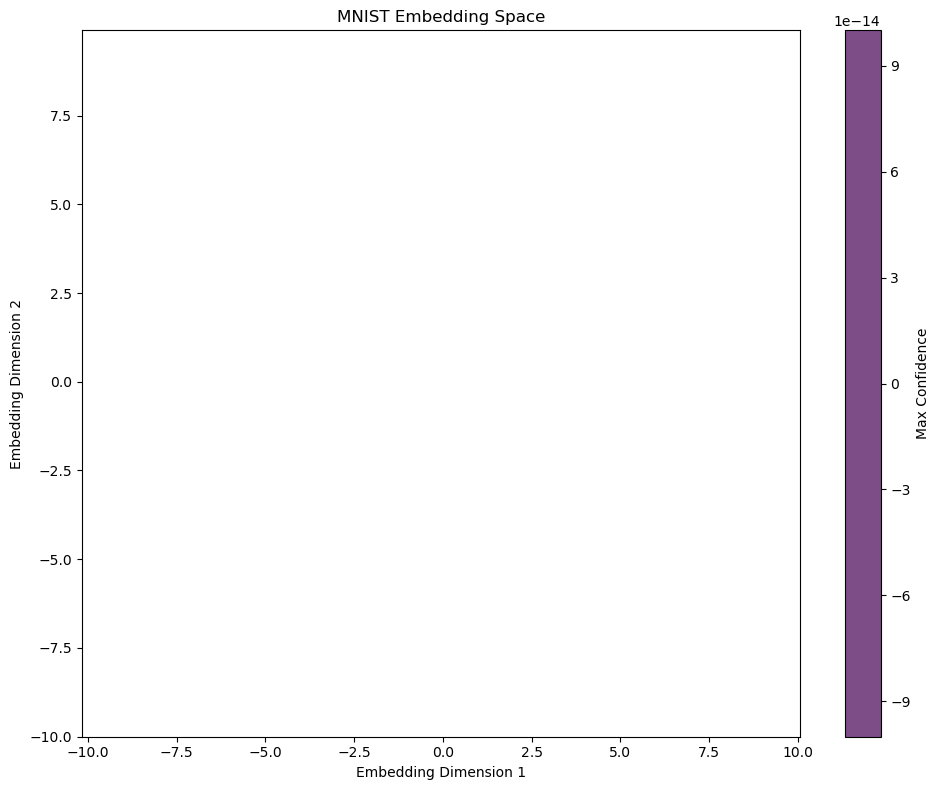


Testing domain transfer with Fashion-MNIST...
Test  - Loss: nan | Acc: 10.000% (1000/10000) | Conf: nan%


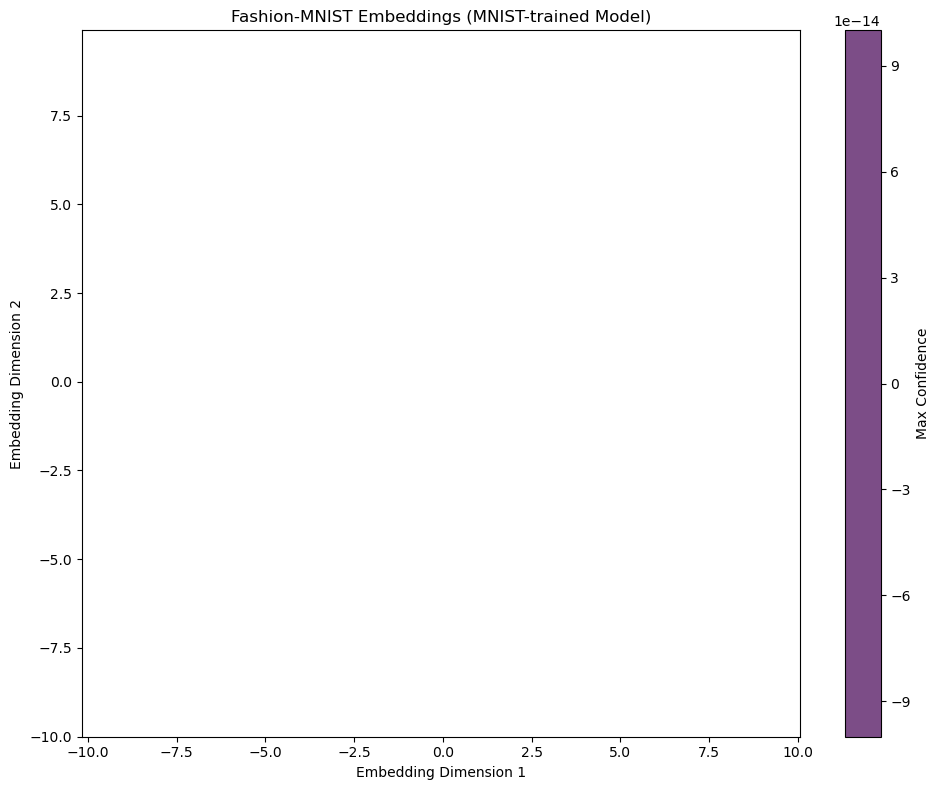


Results Summary:
MNIST Test Accuracy: 9.80%
Fashion-MNIST Accuracy: 10.00%
Domain Transfer Gap: -0.20%


In [5]:
"""Main training and evaluation pipeline."""
# Edit configuration here like so
config = Config(
    epochs=5
)

print("CNN Embedding Space Learning")
print("=" * 50)
print(f"Using device: {config.device}")

# Create data loaders
print("\nPreparing MNIST data...")
mnist_train_loader, mnist_test_loader = create_data_loaders(datasets.MNIST, config)

# Create and setup model
print("Building model...")
model = EmbeddingClassifier(config.embedding_dim, config.num_classes, config)
model = model.to(config.device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=config.learning_rate,
    momentum=config.momentum,
    weight_decay=config.weight_decay
)

# Training loop
print("\nTraining...")
best_accuracy = 0.0

for epoch in range(config.epochs):
    print(f'\nEpoch {epoch + 1}/{config.epochs}:')
    train_epoch(model, criterion, optimizer, mnist_train_loader, config.device)
    test_acc, _ = evaluate_model(model, criterion, mnist_test_loader, config.device)

    if test_acc > best_accuracy:
        best_accuracy = test_acc

# Save model
save_model(model, best_accuracy, config)

# Visualize MNIST embeddings
print("\nVisualizing MNIST embeddings...")
try:
    visualize_embedding_space(model, mnist_test_loader, config, "MNIST Embedding Space")
    plt.show()
except Exception as e:
    print(f"Visualization error: {e}")

# Domain transfer experiment
print("\nTesting domain transfer with Fashion-MNIST...")
fashion_train_loader, fashion_test_loader = create_data_loaders(datasets.FashionMNIST, config)

fashion_acc, _ = evaluate_model(model, criterion, fashion_test_loader, config.device)

# Visualize Fashion-MNIST embeddings
try:
    visualize_embedding_space(
        model, fashion_test_loader, config,
        "Fashion-MNIST Embeddings (MNIST-trained Model)"
    )
    plt.show()
except Exception as e:
    print(f"Visualization error: {e}")

# Summary
print(f"\nResults Summary:")
print(f"MNIST Test Accuracy: {best_accuracy:.2f}%")
print(f"Fashion-MNIST Accuracy: {fashion_acc:.2f}%")
print(f"Domain Transfer Gap: {best_accuracy - fashion_acc:.2f}%")